In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import matplotlib

In [31]:
import sklearn

In [32]:
import os
import logging
import argparse
import glob
import json
from multiprocessing import Pool

from IPython.display import display, Markdown

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image

import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u

from scipy import stats, integrate
from scipy.stats import binom
import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, mean_squared_error, mean_absolute_error
import tensorflow as tf

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses, dirichlet_stats
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning import acquisition_utils
from zoobot import label_metadata


In [33]:
os.chdir('/home/walml/repos/zoobot')

In [34]:
questions = label_metadata.decals_questions
label_cols = label_metadata.decals_label_cols
version = 'decals'

schema = losses.Schema(label_cols, questions, version=version)
schema.questions

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


[smooth-or-featured, indices 0 to 2, asked after None,
 disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1,
 has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4,
 bar, indices 7 to 9, asked after disk-edge-on_no, index 4,
 bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4,
 how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0,
 edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3,
 spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5,
 spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5,
 merging, indices 30 to 33, asked after None]

In [35]:

# previously shared in draft paper
# predictions_loc = 'results/temp/decals_n2_allq_m0_all.csv'
# eval_loc = 'results/temp/decals_n2_allq_m0_eval_shards/eval_df.csv'

# with overzealous cleaning
eval_loc = 'results/decals_dr_full_eval_df.csv'
eval_df = pd.read_csv(eval_loc)
eval_df['local_png_loc'] = eval_df['local_png_loc'].apply(lambda x: x.replace('/data/phys-zooniverse/chri5177', '/media/walml/beta/decals'))
# eval_df doesn't include total-votes, add it
for question in schema.questions:
    eval_df[question.text + '_total-votes'] = np.array([eval_df[answer.text].values for answer in question.answers]).sum(axis=0)

# one model
# predictions_loc = 'results/decals_dr_full_m0_eval_predictions.csv'  # .1-20
# predictions = pd.read_csv(predictions_loc)
# samples = dirichlet_stats.load_all_concentrations(eval_predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers])

# several models (ensemble)
samples = []
predictions_locs = [f'results/decals_dr_full_m{n}_eval_predictions.csv' for n in range(3)]  # 0, 1, 2
for predictions_loc in predictions_locs:
    predictions = pd.read_csv(predictions_loc)
    # filter to eval
    eval_predictions = predictions[predictions['iauname'].isin(eval_df['id_str'])]
    print(len(eval_predictions))
    model_samples = dirichlet_stats.load_all_concentrations(eval_predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers])
    samples.append(model_samples)
samples = np.concatenate(samples, axis=2)

print(samples.shape)



49700
49700
49700
(49700, 34, 15)


In [36]:
is_retired = eval_predictions['smooth-or-featured_total-votes'] > 34
retired = eval_predictions[is_retired]
retired['file_loc'] = retired['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))
retired_samples = samples[is_retired]


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
len(retired)  # only high conf

11346

In [80]:
# predicted_fractions_t2 = dirichlet_stats.dirichlet_prob_of_answers(retired_samples, schema, temperature=.2)

In [92]:
question = schema.get_question('has-spiral-arms')

In [132]:
posteriors_1 = dirichlet_stats.get_posteriors(samples[:5000], eval_df, eval_df['id_str'], question, question.answers[0])

In [133]:
posteriors_2 = dirichlet_stats.get_posteriors(samples[:5000], eval_df, eval_df['id_str'], question, question.answers[0], temperature=.2)

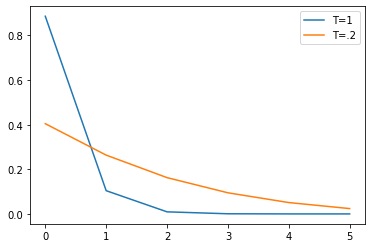

In [134]:
plt.plot(posteriors_1[0][0], posteriors_1[0][1][0], label='T=1')
plt.plot(posteriors_2[0][0], posteriors_2[0][1][0], label='T=.2')
plt.legend()

In [135]:
posteriors_1[0][1].mean()

0.1666673

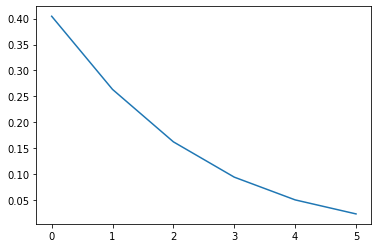

In [136]:
plt.plot(posteriors_2[0][0], posteriors_2[0][1][0], label='T=.2')

In [148]:
posteriors_1[0][0]

array([0., 1., 2., 3., 4., 5.])

In [150]:
(posteriors_1[0][0] * posteriors_1[0][1][0]).mean()

0.020788019190045286

In [147]:
(posteriors_2[0][0] * posteriors_2[0][1][0]).mean()

0.19929264423747858

In [139]:
posteriors_1[0][1][0]

array([8.85923862e-01, 1.04122214e-01, 9.31201968e-03, 6.22269174e-04,
       2.79667238e-05, 6.37467622e-07], dtype=float32)

In [140]:
posteriors_2[0][1][0]

array([0.40440845, 0.26354185, 0.16261092, 0.09465348, 0.05089431,
       0.0238909 ], dtype=float32)

In [141]:
fractions_1[0]

0.1666673

In [151]:
fractions_1 = np.array([(x*p).mean() for (x, p) in posteriors_1])
fractions_2 = np.array([(x*p).mean() for (x, p) in posteriors_2])

In [152]:
fractions_2 - fractions_1

array([ 0.17599548, -0.11918951,  0.        , ...,  0.        ,
       -0.09866866,  0.14691466])

(array([  67.,  102.,   53.,  108.,   69.,   55.,   55.,   55.,   52.,
          42.,   28.,   57.,   51.,   43., 1657.,   46.,   52.,   55.,
          69.,   68.,   74.,  108.,  114.,  152.,  193.,  328.,  367.,
         223.,  438.,  219.]),
 array([-0.19948772, -0.18606427, -0.17264081, -0.15921736, -0.14579391,
        -0.13237045, -0.118947  , -0.10552355, -0.09210009, -0.07867664,
        -0.06525318, -0.05182973, -0.03840628, -0.02498282, -0.01155937,
         0.00186408,  0.01528754,  0.02871099,  0.04213445,  0.0555579 ,
         0.06898135,  0.08240481,  0.09582826,  0.10925171,  0.12267517,
         0.13609862,  0.14952208,  0.16294553,  0.17636898,  0.18979244,
         0.20321589]),
 <a list of 30 Patch objects>)

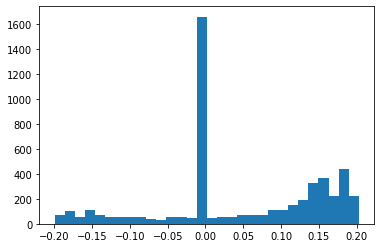

In [153]:
plt.hist(fractions_2 - fractions_1, bins=30)

(array([1614.,    0.,    0.,    4.,   29.,  215.,  410.,  524.,  410.,
         367.,  311.,  264.,  146.,  145.,   93.,  103.,   64.,   57.,
          56.,   52.,   31.,   25.,   17.,   16.,    5.,    9.,    7.,
           8.,    7.,   11.]),
 array([0.        , 0.02909401, 0.05818801, 0.08728202, 0.11637602,
        0.14547003, 0.17456403, 0.20365804, 0.23275204, 0.26184605,
        0.29094005, 0.32003406, 0.34912806, 0.37822207, 0.40731608,
        0.43641008, 0.46550409, 0.49459809, 0.5236921 , 0.5527861 ,
        0.58188011, 0.61097411, 0.64006812, 0.66916212, 0.69825613,
        0.72735013, 0.75644414, 0.78553815, 0.81463215, 0.84372616,
        0.87282016]),
 <a list of 30 Patch objects>)

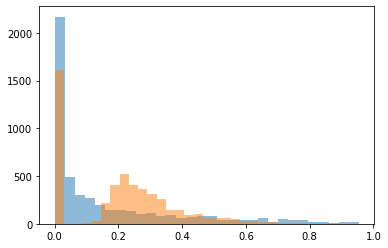

In [154]:
plt.hist(fractions_1, alpha=.5, bins=30)
plt.hist(fractions_2, alpha=.5, bins=30)

In [176]:
question.start_index

5

In [177]:
fractions = np.zeros(shape=(5000, 34))
fractions[:, 5] = fractions_1
fractions[:, 6] = 1 - fractions_1

In [178]:
print_metrics(question, eval_df[:5000], fractions)

Has Spiral Arms & 0.3291 & 0.7100 & 0.3291 & 0.3416 \\


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [163]:
len(fractions_1)

5000

In [164]:
np.sum((fractions_1 > 0.5) & (fractions_2 < 0.5)), np.sum((fractions_1 < 0.5) & (fractions_2 > 0.5))

(187, 0)

In [ ]:
predicted_fractions = fractions_2

In [155]:
# predicted_fractions = dirichlet_stats.dirichlet_prob_of_answers(retired_samples, schema)

In [84]:
predicted_fractions.shape

(11346, 34)

In [82]:
(predicted_fractions - predicted_fractions_t2)[:, 0]

array([0.23841113, 0.00605906, 0.0017458 , ..., 0.250504  , 0.8176042 ,
       0.77220434], dtype=float32)

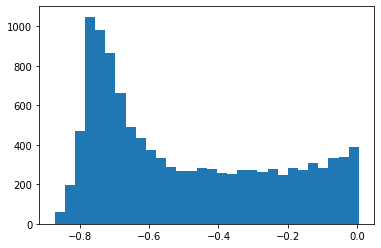

In [83]:
_ = plt.hist((predicted_fractions_t2 - predicted_fractions)[:, 0], bins=30)

In [48]:
# answer = 'smooth-or-featured_smooth'
# answer = schema.get_answer('smooth-or-featured_featured-or-disk')
# answer = schema.get_answer('smooth-or-featured_artifact')
# answer = schema.get_answer('bar_weak')
question = schema.get_question('smooth-or-featured')

In [49]:
len(schema.questions)

10

In [165]:
def get_label(text, question):
    return clean_text(text.replace(question.text, '').title())

In [166]:
def clean_text(text):
    return text.replace('-', ' ').replace('_', '').title()

In [52]:
question

smooth-or-featured, indices 0 to 2, asked after None

In [53]:
# retirement = 1
# predicted_fractions = np.expand_dims(predicted_fractions, axis=-1)
# acquisition_utils.get_expected_votes(samples, question, retirement, schema, round_votes=False).shape

# Discrete Metrics

In [167]:
def filter_to_sensible(label_df, predictions, question):
#     if prev_a is not None:
#         prev_q = prev_a.question
#         prev_q_cols = [answer.text + '_fraction' for answer in prev_q.answers]
#         is_sensible = (label_df[prev_a.text + '_fraction'] / label_df[prev_q_cols].sum(axis=1)) > 0.5
#         valid_labels, valid_predictions = label_df[is_sensible], predicted_fractions[is_sensible]
#     else:
#         valid_labels, valid_predictions = label_df, predicted_fractions
    retirement = 1
    samples = np.expand_dims(predictions, axis=-1)
    expected_votes = acquisition_utils.get_expected_votes_human(label_df, question, retirement, schema, round_votes=False)
    if not isinstance(expected_votes, np.ndarray):
        expected_votes = expected_votes.numpy()  # hack, should fix properly...
#     print(expected_votes)
    is_sensible = expected_votes > 0.5
    valid_labels, valid_predictions = label_df[is_sensible], predictions[is_sensible]
    return valid_labels, valid_predictions


# def get_binary_answers(question, label_df, predicted_fractions):
#     # previous question should be valid
#     valid_labels, valid_predictions = filter_to_sensible(label_df, predicted_fractions, question)
#     cols = [answer.text + '_fraction' for answer in question.answers]
#     y_true = np.argmax(valid_labels[cols].values, axis=1)
#     y_pred = np.argmax(valid_predictions[:, question.start_index:question.end_index+1], axis=1)
#     return y_true, y_pred
    
    
# def print_metrics(question, label_df, predicted_fractions):
#     y_true, y_pred = get_binary_answers(question, label_df, predicted_fractions)
#     print('Acc: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f} <- {})'.format(
#         metrics.accuracy_score(y_true, y_pred),
#         metrics.precision_score(y_true, y_pred, average='micro'),
#         metrics.recall_score(y_true, y_pred, average='micro'),
#         metrics.f1_score(y_true, y_pred, average='micro'),
#         question.text
#     ))

# def show_confusion_matrix(question, label_df, predicted_fractions):
    
#     y_true, y_pred = get_binary_answers(question, label_df, predicted_fractions)
#     cm = confusion_matrix(y_true, y_pred)

#     labels = [get_label(a.text, question) for a in question.answers]
    
#     fig, ax = plt.subplots()
#     ax.set_title(clean_text(question.text))

#     return sns.heatmap(
#         cm,
#         annot=True,
#         cmap='Blues',
#         fmt='d',
#         xticklabels=labels,
#         yticklabels=labels,
#         cbar=False,
#         annot_kws={"size": 14},
#         ax=ax,
#         square=True,
#         robust=True
#     )


In [55]:
len(retired)

11346

In [56]:
np.sum((retired['smooth-or-featured_featured-or-disk_fraction'] * retired['disk-edge-on_no_fraction']) > 0.5)

2859

In [57]:
valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, schema.get_question('has-spiral-arms'))
len(valid_labels)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


2859

In [58]:
retirement = 1  # assumed number of votes at top question
# votes for specific question, given fraction predictions and retirement (=1)
expected_votes = acquisition_utils.get_expected_votes_human(retired, question, retirement, schema, round_votes=False)  

In [168]:
def get_binary_responses(question, label_df, predicted_fractions):
    # previous question should be valid
    valid_labels, valid_predictions = filter_to_sensible(label_df, predicted_fractions, question)
    cols = [answer.text + '_fraction' for answer in question.answers]
    # most likely answer, might be less than .5 though
    y_true = np.argmax(valid_labels[cols].values, axis=1)
    y_pred = np.argmax(valid_predictions[:, question.start_index:question.end_index+1], axis=1)
    return y_true, y_pred

def print_metrics(question, label_df, predicted_fractions):
    y_true, y_pred = get_binary_responses(question, label_df, predicted_fractions)
#     print(pd.value_counts(y_pred))
#     average = 'micro'
    average = 'weighted'
    
    # human
#     print('Acc: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f} <- {}'.format(
#         sklearn.metrics.accuracy_score(y_true, y_pred),
#         sklearn.metrics.precision_score(y_true, y_pred, average=average),
#         sklearn.metrics.recall_score(y_true, y_pred, average=average),
#         sklearn.metrics.f1_score(y_true, y_pred, average=average),
#         question.text
#     ))
    # latex
    print('{} & {:.4f} & {:.4f} & {:.4f} & {:.4f} \\\\'.format(
        question.text.replace('-', ' ').replace('_', ' ').title(),
        sklearn.metrics.accuracy_score(y_true, y_pred),
        sklearn.metrics.precision_score(y_true, y_pred, average=average),
        sklearn.metrics.recall_score(y_true, y_pred, average=average),
        sklearn.metrics.f1_score(y_true, y_pred, average=average)
))

    
def show_confusion_matrix(question, label_df, predicted_fractions):
    y_true, y_pred = get_binary_responses(question, label_df, predicted_fractions)
    
    labels = range(len(question.answers))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    ticklabels = [get_label(a.text, question) for a in question.answers]
    fig, ax = plt.subplots()
    ax.set_title(clean_text(question.text))

    return sns.heatmap(
        cm,
        annot=True,
        cmap='Blues',
        fmt='d',
        xticklabels=ticklabels,
        yticklabels=ticklabels,
        cbar=False,
        annot_kws={"size": 14},
        ax=ax,
        square=True,
        robust=True
    )


## Metrics for all (sensible) galaxies

In [60]:
print('Question & Accuracy & Precision & Recall & F1 \\')
print('\hline \hline')
for question in schema.questions:
    print_metrics(question, retired, predicted_fractions)
#     plt.savefig('/home/walml/repos/zoobot/results/temp/mean_cm_decals_n2_m0_allq_' + question.text + '.png')

Question & Accuracy & Precision & Recall & F1 \
\hline \hline
Smooth Or Featured & 0.9352 & 0.9363 & 0.9352 & 0.9356 \\
Disk Edge On & 0.9871 & 0.9871 & 0.9871 & 0.9871 \\
Has Spiral Arms & 0.9349 & 0.9364 & 0.9349 & 0.9356 \\
Bar & 0.8185 & 0.8095 & 0.8185 & 0.8110 \\
Bulge Size & 0.8419 & 0.8405 & 0.8419 & 0.8409 \\
How Rounded & 0.9314 & 0.9313 & 0.9314 & 0.9313 \\
Edge On Bulge & 0.9111 & 0.9134 & 0.9111 & 0.8996 \\
Spiral Winding & 0.7832 & 0.8041 & 0.7832 & 0.7874 \\
Spiral Arm Count & 0.7742 & 0.7555 & 0.7742 & 0.7560 \\
Merging & 0.8798 & 0.8672 & 0.8798 & 0.8511 \\


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


Acc: 0.934, Global Precision: 0.934, Recall: 0.934, F1: 0.934 <- smooth-or-featured
Acc: 0.988, Global Precision: 0.988, Recall: 0.988, F1: 0.988 <- disk-edge-on
Acc: 0.925, Global Precision: 0.925, Recall: 0.925, F1: 0.925 <- has-spiral-arms
Acc: 0.830, Global Precision: 0.830, Recall: 0.830, F1: 0.830 <- bar
Acc: 0.832, Global Precision: 0.832, Recall: 0.832, F1: 0.832 <- bulge-size
Acc: 0.929, Global Precision: 0.929, Recall: 0.929, F1: 0.929 <- how-rounded
Acc: 0.921, Global Precision: 0.921, Recall: 0.921, F1: 0.921 <- edge-on-bulge
Acc: 0.794, Global Precision: 0.794, Recall: 0.794, F1: 0.794 <- spiral-winding
Acc: 0.767, Global Precision: 0.767, Recall: 0.767, F1: 0.767 <- spiral-arm-count
Acc: 0.888, Global Precision: 0.888, Recall: 0.888, F1: 0.888 <- merging


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


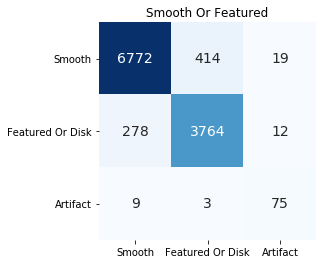

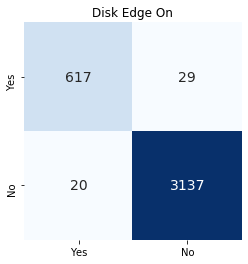

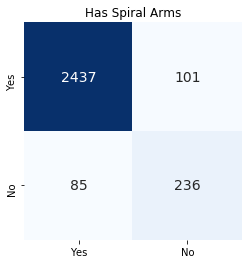

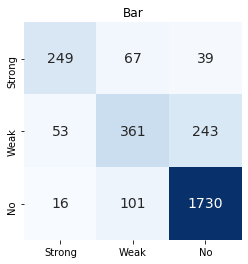

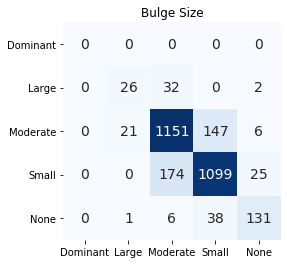

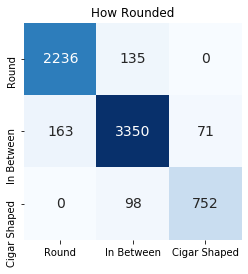

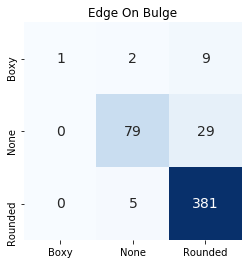

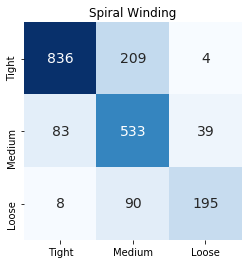

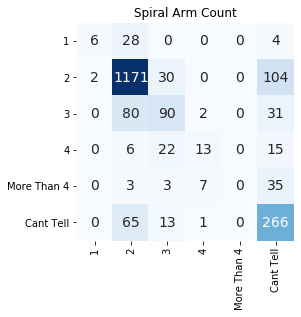

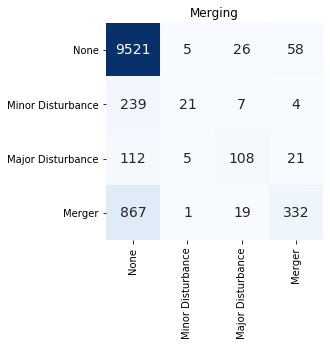

In [61]:
for question in schema.questions:
    fig = show_confusion_matrix(question, retired, predicted_fractions)
#     plt.tight_layout()
#     plt.savefig('/home/walml/repos/zoobot/results/temp/cm_decals_dr_full_ensemble_allq_allconf_' + question.text + '.png')
#     plt.clf()  # comment to view, uncomment to save without interfering with each other

## Metrics for high confidence galaxies

Defining high confidence in multi-q case is harder. Perhaps, that fraction for any one answer?

In [62]:
# high_confidence = (retired[answer.text + '_fraction'] > 0.8) | (retired[answer.text + '_fraction'] < 0.2)
# print_metrics(question, retired[high_confidence], predicted_fractions[high_confidence])

# show_confusion_matrix(question, retired[high_confidence], predicted_fractions[high_confidence])

Question & Accuracy & Precision & Recall & F1 \\
\hline \hline
Smooth Or Featured & 0.9997 & 0.9997 & 0.9997 & 0.9997 \\
Disk Edge On & 0.9980 & 0.9980 & 0.9980 & 0.9980 \\
Has Spiral Arms & 0.9921 & 0.9933 & 0.9921 & 0.9924 \\


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


Bar & 0.9945 & 0.9964 & 0.9945 & 0.9951 \\
Bulge Size & 1.0000 & 1.0000 & 1.0000 & 1.0000 \\
How Rounded & 0.9968 & 0.9968 & 0.9968 & 0.9968 \\
Edge On Bulge & 0.9961 & 0.9961 & 0.9961 & 0.9961 \\
Spiral Winding & 0.9906 & 1.0000 & 0.9906 & 0.9953 \\
Spiral Arm Count & 0.9863 & 0.9891 & 0.9863 & 0.9871 \\
Merging & 0.9987 & 0.9987 & 0.9987 & 0.9987 \\


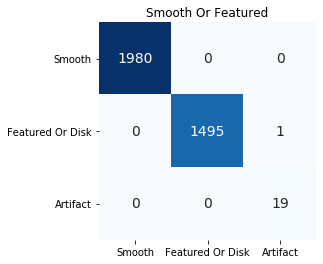

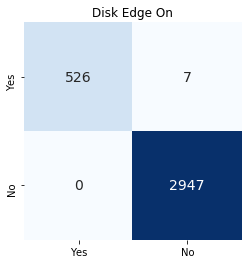

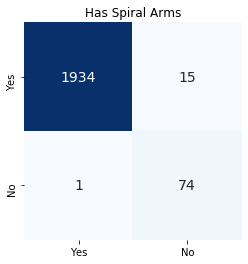

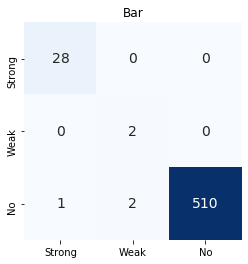

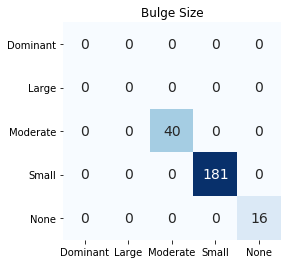

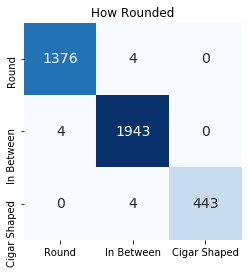

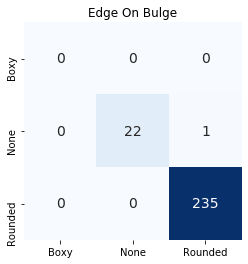

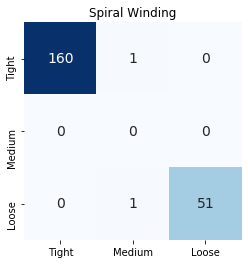

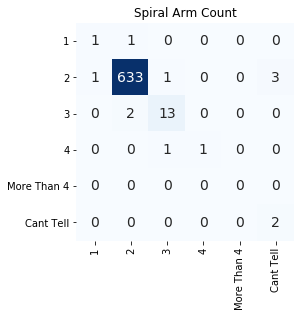

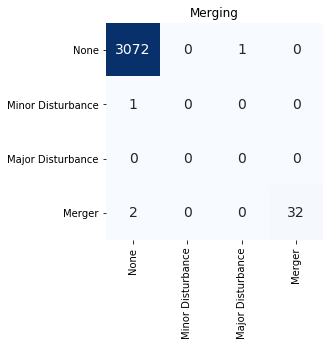

In [63]:
print(r'Question & Accuracy & Precision & Recall & F1 \\')
print('\hline \hline')
for question in schema.questions:
#     if len(question.answers) == 2:
#         answer = question.answers[0]
    answers = question.answers
    fractions = np.array([retired[answer.text + '_fraction'] for answer in answers])
    high_confidence = np.any(fractions > 0.8, axis=0)
    print_metrics(question, retired[high_confidence], predicted_fractions[high_confidence])
    fig = show_confusion_matrix(question, retired[high_confidence], predicted_fractions[high_confidence])
#     plt.savefig('/home/walml/repos/zoobot/results/temp/cm_decals_dr_full_ensemble_allq_highconf_' + question.text + '.png')
#     plt.clf()  # comment to view, uncomment to save without interfering with each other

In [28]:
assert False

AssertionError: 

In [ ]:
for question in schema.questions:
    for answer in question.answers:
        retired[answer.text + '_ml_fraction'] = predicted_fractions[:, answer.index]

In [ ]:
question = schema.get_question('spiral-arm-count')
answer = schema.get_answer('spiral-arm-count_cant-tell')

In [ ]:
confused_cant_tell_arms = retired[answer.text + '_fraction'] 

In [ ]:


valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, question)
y_true, y_pred = get_binary_responses(question, valid_labels, valid_predictions)

In [ ]:
cant_tell_confused_with_two = (y_true == 5) & (y_pred == 1)
two_confused_with_cant_tell = (y_true == 1) & (y_pred == 5)

In [ ]:
valid_labels[cant_tell_confused_with_two]['locations'].values[:5]

In [ ]:
retired['spiral-arm-count_2_ml_fraction']

In [ ]:
retired['spiral-arm-count_cant-tell_ml_fraction']

In [ ]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=6, ncols=6):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows * 1.505, scale * ncols / 2.59))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            image = Image.open(galaxy['file_loc'])
            ax = plt.subplot(gs1[row_n, col_n])
            ax.imshow(image)
            ax.text(35, 50, 'Vol: 2={:.2f}, ?={:.2f}'.format(galaxy['spiral-arm-count_2_fraction'], galaxy['spiral-arm-count_cant-tell_fraction']), fontsize=12, color='r')
            ax.text(35, 100, 'ML: 2={:.2f}, ?={:.2f}'.format(galaxy['spiral-arm-count_2_ml_fraction'], galaxy['spiral-arm-count_cant-tell_ml_fraction']), fontsize=12, color='r')
#             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
#             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
    fig.tight_layout()
    return fig


In [ ]:
_ = show_galaxies(valid_labels[cant_tell_confused_with_two].sample(8), nrows=2, ncols=4)

In [ ]:
_ = show_galaxies(valid_labels[two_confused_with_cant_tell].sample(8), nrows=2, ncols=4)

# Regression Metrics

In [ ]:
errors = []
min_total_votes = 20
for question_n, question in enumerate(schema.questions):
    for answer in question.answers:
        print(question.text, answer.text)
        valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, question)  # df, np.array
        valid_labels.reset_index()
        enough_votes = valid_labels[question.text + '_total-votes'] >= min_total_votes  # not quite the same as filter_to_sensible
        y_true = valid_labels.loc[enough_votes, answer.text + '_fraction']
        y_pred = valid_predictions[enough_votes, answer.index]
        assert not pd.isna(y_true).any()
        assert not pd.isna(y_pred).any()
        absolute = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        errors.append({'answer': answer.text, 'rmse': np.sqrt(mse), 'mean_absolute_error': absolute, 'question_n': question_n})

metrics = pd.DataFrame(errors)


In [ ]:
colorbrewer = [
    '#8dd3c7',
    '#ffffb3',
    '#bebada',
    '#fb8072',
    '#80b1d3',
    '#fdb462',
    '#b3de69',
    '#fccde5',
    '#d9d9d9',
    '#bc80bd'
]
base_palette = sns.color_palette(colorbrewer)


In [ ]:
# base_palette = sns.husl_palette(len(schema.questions))
# base_palette = sns.choose_colorbrewer_palette('qualitative')

# import random
# random.shuffle(base_palette)
# sns.palplot(base_palette)

In [ ]:
repeating_palette = []
for q_n, question in enumerate(schema.questions):
    for a_n, answer in enumerate(question.answers):
        repeating_palette.append(base_palette[q_n])

In [ ]:
sns.set_style('whitegrid', {'axes.edgecolor': '0.2'})
sns.set_context('notebook')
sns.set_palette(repeating_palette)
fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(data=metrics, y='answer', x='mean_absolute_error', ax=ax)
plt.xlabel('Vote Fraction Mean Deviation')
plt.ylabel('')
fig.tight_layout()
# plt.savefig('mean_deviation_bar.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=metrics, y='answer', x='rmse', ax=ax)

In [ ]:

# question = schema.get_question('has-spiral-arms')
answer = schema.get_answer('bulge-size_moderate')
question = answer.question
# answer = question.answers[0]
valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, question)
sns.scatterplot(valid_labels[answer.text + '_fraction'], valid_predictions[:, answer.index], alpha=.1)



In [ ]:
plt.hist(valid_labels[question.text + '_total-votes'], bins=40, range=(0, 60))

In [ ]:
question.asked_after

In [ ]:
valid_labels.iloc[np.argsort(valid_labels[question.text + '_total-votes'])[:10]]['smooth-or-featured_featured-or-disk_fraction']

In [ ]:
plt.hist(valid_labels[answer.text + '_fraction'], bins=40)

In [ ]:
valid_labels['smooth-or-featured_total-votes'].hist(bins=30, range=[0., 120])

In [ ]:

fig, axes = plt.subplots(nrows=len(label_cols), figsize=(8, len(label_cols) * 3))
ax_n = 0
for question in schema.questions:
    valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, question)
    for answer in question.answers:
        sns.scatterplot(valid_labels[answer.text + '_fraction'], valid_predictions[:, answer.index], ax=axes[ax_n], alpha=.14)
        ax_n += 1


In [ ]:
retired['smooth-or-featured_total-votes'].hist(bins=30)

In [ ]:
is_intense = retired['smooth-or-featured_total-votes'] > 75
intense_labels, intense_predictions = retired[is_intense], predicted_fractions[is_intense]

In [ ]:
def mimic_fewer(galaxy, question):
    data = []
    n_answers = len(question.answers)
    actual_votes = galaxy[[a.text for a in question.answers]].values
    actual_fractions = actual_votes / actual_votes.sum()
    total_votes = actual_votes.sum()
    
    removed_votes = 0
    latest_votes = actual_votes.copy()
    while removed_votes < total_votes:
        fractions = np.array([latest_votes[answer_n]/latest_votes.sum() for answer_n in range(n_answers)])
        assert latest_votes.sum() + removed_votes == total_votes
        data.append({'n_votes': total_votes - removed_votes, 'votes': latest_votes.copy(), 'fractions': fractions, 'deviations': np.abs(fractions - actual_fractions)})
        
#         answer_above_0 = latest_votes > 0
#         valid_answer_indices = np.arange(n_answers)[answer_above_0]
#         index_to_reduce = np.random.choice(valid_answer_indices)
        index_to_reduce = np.random.choice(np.arange(n_answers), p=fractions)
        latest_votes[index_to_reduce] = latest_votes[index_to_reduce] - 1
        removed_votes += 1
        
    return data
            

In [ ]:
question = schema.get_question('smooth-or-featured')
# question = schema.get_question('has-spiral-arms')
# question = schema.get_question('bar')
# question = schema.get_question('bulge-size')
galaxy = intense_labels.sample().squeeze()
mimic = pd.DataFrame(data=mimic_fewer(galaxy, question))

# sns.set()
# n_votes = mimic['n_votes']
# fractions = np.stack(mimic['fractions'], axis=0)
# for answer_n, answer in enumerate(question.answers):
#     print(answer.text)
#     plt.plot(n_votes, fractions[:, answer_n], label=answer.text)
#     plt.axhline(mimic.sort_values('n_votes')['fractions'].iloc[-1][answer_n], linestyle='--', color='k', alpha=.5)
# plt.legend()

In [ ]:
# mimic['deviations']

In [ ]:
# sns.set()
# deviations = np.stack(mimic['deviations'], axis=0)
# n_votes = mimic['n_votes']
# for answer_n, answer in enumerate(question.answers):
#     print(answer.text)
#     plt.plot(n_votes, deviations[:, answer_n], label=answer.text)
# plt.legend()

In [ ]:
deviations

In [ ]:
data = []
valid_intense, _ = filter_to_sensible(intense_labels, intense_predictions, question)
# print(len(valid_intense))
for n_votes in np.arange(1, 40):
    print(n_votes)
    all_deviations = []
    for _, galaxy in valid_intense.iterrows():
        mimic = pd.DataFrame(data=mimic_fewer(galaxy, question))
        deviations = mimic.query(f'n_votes == {n_votes}')['deviations'].squeeze()
        assert len(deviations) > 0
#         assert deviations.shape == (len(question.answers),)
        all_deviations.append(deviations)
    all_deviations = np.stack(all_deviations, axis=0)
    mean_abs = all_deviations.mean(axis=0)
    result = {'n_votes': n_votes}
    result.update(dict(zip([a.text for a in question.answers], mean_abs)))
    data.append(result)

In [ ]:
deviation_df = pd.DataFrame(data=data)

In [ ]:
def convert_to_label(x):
    return x.replace(question.text, '').replace('_', '').capitalize()

In [ ]:
# colors = sns.color_palette('mako', 5)
# colors = sns.color_palette('mako')
# colors = base_palette

# colorbrewer = [
#     '#8dd3c7',
#     '#ffffb3',
#     '#bebada',
#     '#fb8072',
#     '#80b1d3',
#     '#fdb462',
#     '#b3de69',
#     '#fccde5',
#     '#d9d9d9',
#     '#bc80bd'
# ]
# colors = sns.color_palette(colorbrewer[-5:])


In [ ]:
# prob_of_answers = np.expand_dims(galaxy[[a.text + '_fraction' for a in schema.answers]], axis=0)
# galaxy['smooth-or-featured_featured-or-disk_fraction']                         
# deviation_df['n_votes_total'] = deviation_df['n_votes'] / schema.joint_p(prob_of_answers, question.asked_after.text)  # looks more impressive, but is maybe a level of complexity too far - not used

In [ ]:
sns.set_context('notebook')
sns.set(font_scale=1.3, style='whitegrid', rc={'grid.linewidth': .5})  # softening the grid lines

colors = sns.color_palette('deep', len(question.answers))
# colors = ['y', 'b', 'g', 'r', 't']

for a_n, a in enumerate(question.answers):

    # exclude 'dominant' for bulge, rare  question.answers[1:]
    # exclude no for spiral, no need      if a_n == 0:
    sns.lineplot(data=deviation_df, x='n_votes', y=a.text, color=colors[a_n], label=convert_to_label(a.text), marker='.', markersize=10.)
    plt.axhline(metrics.query(f'answer == "{a.text}"').squeeze()['mean_absolute_error'], color=colors[a_n], linestyle='--')
plt.legend()
plt.ylabel('Mean error vs. all votes')
plt.xlabel('Truncated number of votes')
# if question.text == 'smooth-or-featured':
plt.xlim([0, 20])
plt.ylim(0., .25)
# if question.text == 'bulge-size':
#     plt.xlim([0, 20])
#     plt.ylim(0., .25)
plt.title(question.text.replace('-', ' ').title())  # .title = capitalize each word (isn't python <3)
plt.tight_layout()
plt.savefig('notebooks/multiq/performance/vs_all_votes_' + question.text + '.png')
plt.savefig('notebooks/multiq/performance/vs_all_votes_' + question.text + '.pdf')